In [1]:
!pip install datasets
!pip install tf-keras
!pip install accelerate -U
!pip install evaluate
!pip install numpy==1.26.4
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Load dataset

In [2]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('nlp-getting-started/train.csv')

In [3]:
print(dataset)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

## Preprocess

In [4]:
dataset['keyword'].fillna('missing', inplace=True)
dataset['location'].fillna('unknown', inplace=True)

/tmp/ipykernel_770/868105977.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['keyword'].fillna('missing', inplace=True)
/tmp/ipykernel_770/868105977.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

Data cleaning

In [5]:
import re
import string

def remove_URL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    return url_pattern.sub('', text)

def remove_html(text):
    html_pattern = re.compile(r'<.*?>') 

    return html_pattern.sub('', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

def remove_punct(text):
    translator = str.maketrans('', '', string.punctuation)
    
    return text.translate(translator)

In [6]:
dataset['text'] = dataset['text'].apply(lambda x: remove_URL(x))
dataset['text'] = dataset['text'].apply(lambda x: remove_html(x))
dataset['text'] = dataset['text'].apply(lambda x: remove_emoji(x))
dataset['text'] = dataset['text'].apply(lambda x: remove_punct(x))

In [7]:
print(dataset)

         id  keyword location  \
0         1  missing  unknown   
1         4  missing  unknown   
2         5  missing  unknown   
3         6  missing  unknown   
4         7  missing  unknown   
...     ...      ...      ...   
7608  10869  missing  unknown   
7609  10870  missing  unknown   
7610  10871  missing  unknown   
7611  10872  missing  unknown   
7612  10873  missing  unknown   

                                                   text  target  
0     Our Deeds are the Reason of this earthquake Ma...       1  
1                 Forest fire near La Ronge Sask Canada       1  
2     All residents asked to shelter in place are be...       1  
3     13000 people receive wildfires evacuation orde...       1  
4     Just got sent this photo from Ruby Alaska as s...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  ariaahrary TheTawniest The out of control wild...       1  
7610     

In [8]:
from sklearn.model_selection import train_test_split

# # AUTO = tf.data.experimental.AUTOTUNE
# X = ds_train["text"]
# y = ds_train["target"]

# Split the ds_train into training (80%) and validation (20%) sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
ds_train, ds_valid = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset['target']) # Stratified splitting

# # Depending on the 'train' flag, assign the correct data (training or validation)
# X, y = (X_train, y_train) if True else (X_val, y_val)

Turn pandas dataframe into dataset

In [9]:
from datasets import Dataset, DatasetDict
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(ds_train),
    "eval": Dataset.from_pandas(ds_valid)
})

print("Dataset Dict:\n", raw_datasets)

Dataset Dict:
 DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', '__index_level_0__'],
        num_rows: 6090
    })
    eval: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', '__index_level_0__'],
        num_rows: 1523
    })
})


Tokenizing

In [10]:
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
    
tokenized_disaster = raw_datasets.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print(tokenized_disaster)

2025-01-08 17:03:15.281770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 17:03:15.293869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736355795.308113     770 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736355795.312440     770 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 17:03:15.327529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 6090
    })
    eval: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1523
    })
})


In [11]:
tokenized_disaster = tokenized_disaster.remove_columns(['id', 'keyword', 'location', 'text', '__index_level_0__'])
tokenized_disaster = tokenized_disaster.rename_column("target", "labels")
print(tokenized_disaster)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6090
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1523
    })
})


train

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments, Trainer, get_scheduler, TrainerCallback
import torch.optim as optim
import evaluate

stopped_epoch = 0  # record early stopping epochs. (變數用來記錄早停的 epoch)

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience, min_delta):
        self.patience = patience  # patience=3: Default allows up to 3 epochs without progress. (默認允許最多 3 個 epoch 沒有進步。)
        self.min_delta = min_delta  # min_delta=0: Any improvement is considered progress. (只要有任何改善，就會被認為是進步。)
        self.counter = 0  # Counter for epochs without improvement
        self.early_stop = False
        self.best_score = None  # track the best evaluation score

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        global stopped_epoch

        # train_loss = metrics.get("train_loss")
        eval_loss = metrics.get("eval_loss")

        if eval_loss is not None:
            if self.best_score is None or (self.best_score - eval_loss) > self.min_delta:
                self.best_score = eval_loss
                self.counter = 0  # Reset counter if improvement is seen
            else:
                self.counter += 1
                if self.counter >= self.patience:  # stop training
                    self.early_stop = True
                    control.should_training_stop = True
                    stopped_epoch = state.epoch
                    print(f"Early stopping triggered at epoch {stopped_epoch}")

training_args = TrainingArguments(
    output_dir="my_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_strategy="epoch", # record every epoch
    report_to="none",  # Disable W&B logging
)

def compute_metrics(eval_pred):
    metric = evaluate.load("glue", "mrpc") # F1 and Accuracy
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

scheduler = get_scheduler(
    name="linear",  # Scheduler type
    optimizer=optimizer,
    num_warmup_steps=0,  # Number of warmup steps
    num_training_steps=training_args.num_train_epochs * len(tokenized_disaster["train"]) // training_args.per_device_train_batch_size
)

trainer = Trainer(
    model=model,
    args=training_args,
    optimizers=(optimizer, scheduler),
    train_dataset=tokenized_disaster["train"],
    eval_dataset=tokenized_disaster["eval"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(patience=3, min_delta=0)],
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.459900,0.377579,0.847012,0.807914
2,0.357600,0.378664,0.847669,0.818182
3,0.302600,0.425918,0.841760,0.816451
4,0.252900,0.460428,0.842416,0.810726


Early stopping triggered at epoch 4.0


TrainOutput(global_step=1524, training_loss=0.34325097051505343, metrics={'train_runtime': 201.2354, 'train_samples_per_second': 302.631, 'train_steps_per_second': 18.933, 'total_flos': 209084265255216.0, 'train_loss': 0.34325097051505343, 'epoch': 4.0})

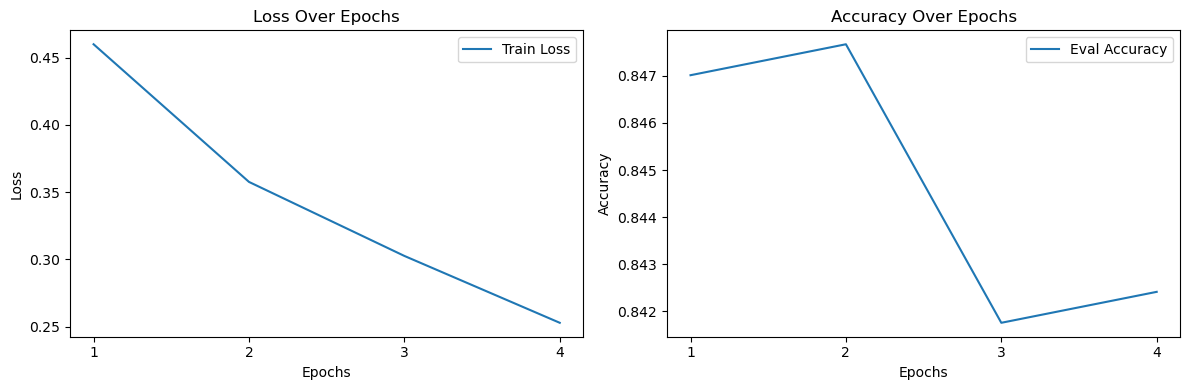

In [14]:
import matplotlib.pyplot as plt

stopped_epoch2 = int(stopped_epoch)

# Extract logged metrics for plotting
train_losses = [
    log["loss"] for log in trainer.state.log_history if "loss" in log
]
eval_accuracies = [
    log["eval_accuracy"] for log in trainer.state.log_history if "eval_accuracy" in log
]

# Ensure only the first 10 epochs are used (since we trained for 10 epochs)
train_losses = train_losses[:stopped_epoch2]  # Limit to 10 epochs
eval_accuracies = eval_accuracies[:stopped_epoch2]  # Limit to 10 epochs

epochs = range(0, stopped_epoch2, 1)  # Fixed range for 10 epochs

# Plot Loss and Accuracy
plt.figure(figsize=(12, stopped_epoch2))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.xticks(range(len(train_losses)), labels=range(1, len(train_losses) + 1))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_accuracies, label="Eval Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.xticks(range(len(eval_accuracies)), labels=range(1, len(eval_accuracies) + 1))

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt


def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    # f1_score = tp / (tp+((fn+fp)/2))
    # f1 = f1_score(y_true, np.argmax(y_pred, axis=1))

    # disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1.round(2)))
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset")

              precision    recall  f1-score   support

           0      0.846     0.885     0.865       869
           1      0.837     0.786     0.811       654

    accuracy                          0.842      1523
   macro avg      0.842     0.835     0.838      1523
weighted avg      0.842     0.842     0.842      1523



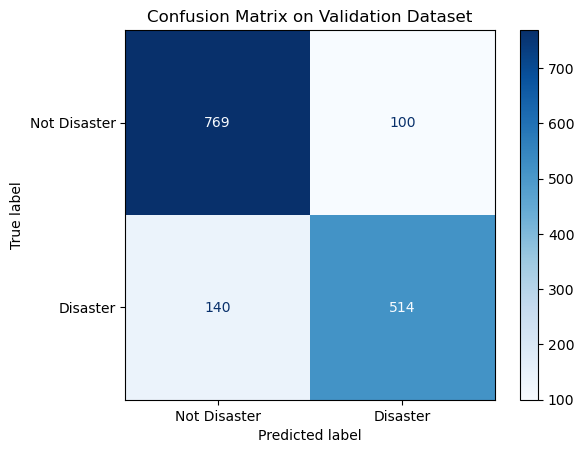

In [17]:
# Confusion Matrix on Validation Dataset

# Make prediction on evaluation dataset
y_pred_val = trainer.predict(tokenized_disaster["eval"]).predictions
y_pred_val2 = np.argmax(y_pred_val, axis=1)

# Get the true labels
y_true = tokenized_disaster["eval"]["labels"]
y_true2 = np.array(y_true)

# Print the classification report
print(classification_report(y_true2, y_pred_val2, digits=3))

displayConfusionMatrix(y_true, y_pred_val, "Validation")